#### Тояков А. О. Группа: М8о-407б-18

Структура Перцептрона Розенблата. Мы будем строить слой из таких перцептронов в зависимости от того, на сколько классов надо разбить данные. По условию - выход перцептрона $net$, поэтому из схемы ниже нужно изключить пороговую функцию активации.

![title](./picture.jpg)

# Алгоритм обучения


Если дана $(X, Y)$ - обучающая выборка, то задача - найти веса и смещение $(W, b)$ для каждого парцептрона из слоя. Алгоритм работает за заданное $N$ количество шагов, или пока веса не перестанут меняться.

1. Инициализация весов и смещения случайным образом. Номер шага $k = 0$.
2. Пока веса изменяются и k < N:
   
      Для каждого поданного на вход значения $p_i \in X$, $ \forall i:$ 0 $\leq i < |X|$:                       
      Если: $y_i (p_i \cdot W + b) < 0$, cчитаем ошибку $e = y_i - (p_i \cdot W + b)$ меняем веса:

$$W = W + e*p_i$$$$b = b +e$$

3. Полученные веса и смещения - результат обучения.

# Реализация сети

При обучении добавим к тренировочным данным еденичный столбец для смещения.

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [7]:
class RosenblattLayer:
    def __init__(self, steps = 50, early_stop = False):
        self.steps = steps
        self.w = None
        self.negative_is_zero = False
        self.early_stop = early_stop
    
    def fit(self, X, y):
        # add column for bias and transpose data for comphort operations:
        X_t = np.append(X, np.ones((1, X.shape[1])), axis = 0).T
        y_t = np.array(y.T)
        
        if (y_t == 0).sum():
            self.negative_is_zero = True
            y_t[y_t == 0] = -1

        #init weights
        if self.w is None:
            self.w = np.random.random((X_t.shape[1], y_t.shape[1]))
        
        # main loop
        
        for step in tqdm(range(self.steps)):
            stop = True
            for i in range(X_t.shape[0]):
                # compute error of all perceptrons
                predict = X_t[i].dot(self.w)
                if np.sum(predict*y_t[i] < 0):
                    stop = False
                    e = y_t[i] - X_t[i].dot(self.w)
                    e[predict*y_t[i] >= 0] = 0.0
                    self.w += X_t[i].reshape(X_t.shape[1], 1).dot(e.reshape(1, y_t.shape[1]))
            if stop and self.early_stop:
                break
                
        return self

    def set_steps(self, steps):
        self.steps = steps
        
    def set_early_stop(self, stop):
        self.early_stop = stop
    
    # Predict answers
    def predict(self, X):
        X_t = np.append(X, np.ones((1, X.shape[1])), axis = 0).T
        return X_t.dot(self.w).T
    
    def predict_classes(self, X):
        X_t = np.append(X, np.ones((1, X.shape[1])), axis = 0).T
        ans = X_t.dot(self.w)
        a_t =  ans < 0
        if self.negative_is_zero:
            ans[a_t] = 0
        else:
            ans[a_t] = -1
        ans[np.logical_not(a_t)] = 1
        return ans.T
    
    def display(self):
        ans = " Input(n," + str(self.w.shape[0] - 1) + ")  -->  "
        ans += "Rosenblat Perceptrons(" + str(self.w.shape[1]) + ")  -->  "
        ans += "Output(n, " + str(self.w.shape[1]) + ")"
        return ans
    
    def weights(self):
        return self.w[:-1]
    
    def bias(self):
        return self.w[-1]
    
    def score(self, X, y):
        X_t = np.append(X, np.ones((1, X.shape[1])), axis = 0).T
        y_t = np.array(y.T)
        y_t[y_t == 0] = -1
        return np.abs(y_t - X_t.dot(self.w)).mean()

# Решение
## Задание №1
Данные:

In [8]:

P = np.array([
    [-3.8, -2.1, 1.5, 4.3, -2.6, -2.5],
    [-4.8, -1.9, 4.5,-0.5, 2.6, 2.4]
])

T = np.array([[1, 1, 1, 0, 1, 0]])

Инициализируем модель и посмотрим архитектуру:

In [9]:
model = RosenblattLayer(0).fit(P, T)
print(model.display())

0it [00:00, ?it/s]

 Input(n,2)  -->  Rosenblat Perceptrons(1)  -->  Output(n, 1)


Построение графика по весам модели:

In [11]:
def plot_line(weights, bias):
    x = list(np.arange(-5, 5, 0.01))
    for i in range(bias.shape[0]):
        w = weights[:, i].ravel()
        b = bias[i]
        y = list(map(lambda t: (-w[0]/w[1])*t - b/w[1], x))
        plt.plot(x, y, label="Перцептрон №" + str(i+1))

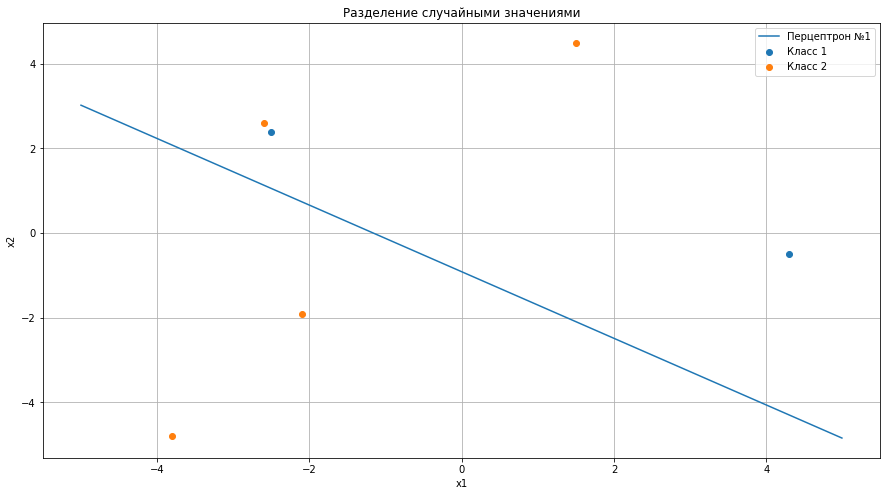

In [12]:
plt.figure(figsize=(15, 8))
plot_line(model.weights(), model.bias())
plt.scatter(P.T[T.ravel() == 0].T[0], P.T[T.ravel() == 0].T[1], label="Класс 1")
plt.scatter(P.T[T.ravel() == 1].T[0], P.T[T.ravel() == 1].T[1], label="Класс 2")
plt.title("Разделение случайными значениями")
plt.xlabel("x1")
plt.ylabel("x2")
plt.grid()
plt.legend()


Обучим модель на 50 эпох:

In [13]:
model.set_steps(50)
model.set_early_stop(True)
model.fit(P, T)

100%|██████████| 50/50 [00:00<00:00, 7775.00it/s]


Результат обучения:

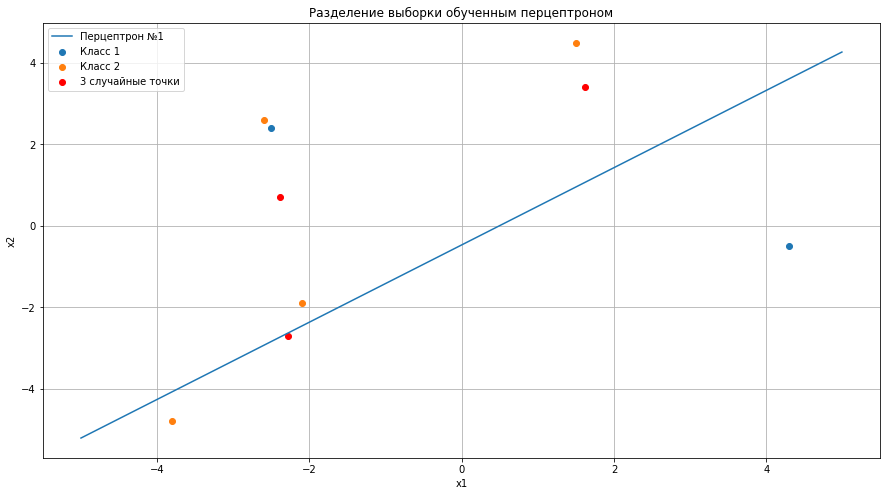

In [14]:
plt.figure(figsize=(15, 8))
plot_line(model.weights(), model.bias())
plt.scatter(P.T[T.ravel() == 0].T[0], P.T[T.ravel() == 0].T[1], label="Класс 1")
plt.scatter(P.T[T.ravel() == 1].T[0], P.T[T.ravel() == 1].T[1], label="Класс 2")
x = np.random.randint(-5, 4, 3) + np.random.random(3)
y = np.random.randint(-5, 4, 3) + np.random.random(3)
plt.scatter(x, y, color="red", label="3 случайные точки")
plt.xlabel("x1")
plt.ylabel("x2")

plt.title("Разделение выборки обученным перцептроном")
plt.grid()
plt.legend()

In [15]:
test = np.append(x.reshape(1, 3), y.reshape(1, 3), axis=0)
print("Test Data:")
print(test)
print("Predict:")
print(model.predict_classes(test))

Test Data:
[[-2.27891398 -2.39087079  1.61474385]
 [-2.70370122  0.70815301  3.41238253]]
Predict:
[[1. 0. 0.]]


Выход модели на тренировочных данных:

In [16]:
model.predict(P) ## result of net func

array([[ 3.78342180e+158, -2.88629326e+158, -1.83517547e+159,
         2.13296164e+159, -2.86663534e+159, -2.71381075e+159]])

Полученные классы:

In [17]:
model.predict_classes(P)

array([[1., 0., 0., 1., 0., 0.]])

In [18]:
model.score(P, T)

1.7025924490743194e+159

Коэффиценты и смещения:

In [19]:
print("Веса:")
print(model.weights())
print("Смещения:")
print(model.bias())

Веса:
[[ 4.91741280e+158]
 [-5.18252304e+158]]
Смещения:
[-2.40652016e+158]


## Задание №2
Сделаем выборку неразделимой:

In [21]:
P = np.append(P, np.array([[0], [-4]]), axis=1)
T = np.append(T, np.array([[1]]), axis=1)


Как видим обучение прошло все шаги:

In [22]:
model = RosenblattLayer(50, True)
model.fit(P, T)

100%|██████████| 50/50 [00:00<00:00, 3623.84it/s]


Результат обучения:

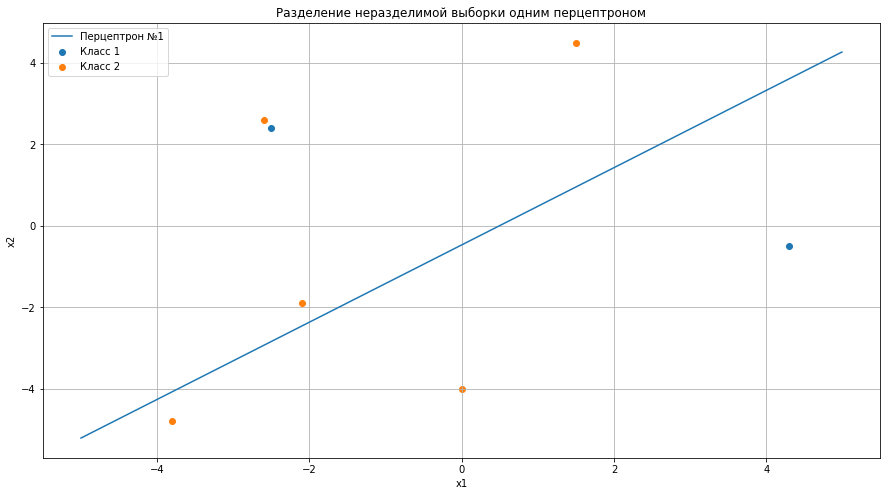

In [24]:
plt.figure(figsize=(15, 8))
plot_line(model.weights(), model.bias())
plt.scatter(P.T[T.ravel() == 0].T[0], P.T[T.ravel() == 0].T[1], label="Класс 1")
plt.scatter(P.T[T.ravel() == 1].T[0], P.T[T.ravel() == 1].T[1], label="Класс 2")
plt.xlabel("x1")
plt.ylabel("x2")

plt.title("Разделение неразделимой выборки одним перцептроном")
plt.grid()
plt.legend()

Как видим, модель допускает ошибки:

In [25]:
model.predict_classes(P) == T # only 2 true


array([[ True, False, False, False, False,  True,  True]])

## Задание №3
Данные:

In [26]:
P = np.array([
    [-4.0, -3.4, 0.7, 4.3, 2.3, 3.6, 4.8, 2.8],
    [-3.6, 1.2, -4.5, 2.2, -4.4, 4.3, 3.5, 0.1]
])

T = np.array([
    [0, 0, 0, 1, 0, 1, 1, 0],
    [1, 1, 0, 0, 0, 1, 0, 0]
])

Модель и ее структура:

In [27]:
model = RosenblattLayer(0).fit(P, T)
print(model.display())

0it [00:00, ?it/s]

 Input(n,2)  -->  Rosenblat Perceptrons(2)  -->  Output(n, 2)


In [28]:
model.set_steps(50)
model.set_early_stop(True)
model.fit(P, T)

100%|██████████| 50/50 [00:00<00:00, 5237.12it/s]


Посмотрим на разделение:

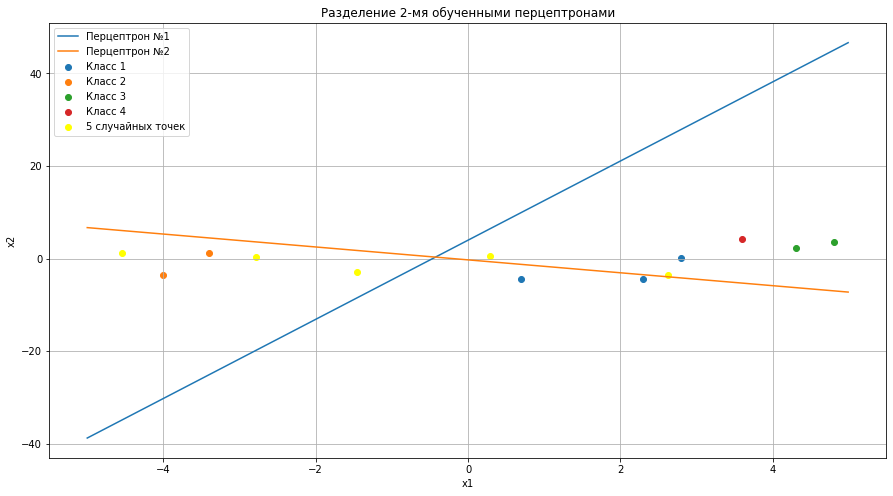

In [29]:

plt.figure(figsize=(15, 8))
plot_line(model.weights(), model.bias())
plt.scatter(
    P.T[(T[0] == 0) & (T[1] == 0)].T[0], 
    P.T[(T[0] == 0) & (T[1] == 0)].T[1], 
    label="Класс 1"
)
plt.scatter(
    P.T[(T[0] == 0) & (T[1] == 1)].T[0], 
    P.T[(T[0] == 0) & (T[1] == 1)].T[1], 
    label="Класс 2"
)
plt.scatter(
    P.T[(T[0] == 1) & (T[1] == 0)].T[0], 
    P.T[(T[0] == 1) & (T[1] == 0)].T[1], 
    label="Класс 3"
)
plt.scatter(
    P.T[(T[0] == 1) & (T[1] == 1)].T[0], 
    P.T[(T[0] == 1) & (T[1] == 1)].T[1], 
    label="Класс 4"
)

x = np.random.randint(-5, 4, 5) + np.random.random(5)
y = np.random.randint(-5, 4, 5) + np.random.random(5)

plt.xlabel("x1")
plt.ylabel("x2")
plt.scatter(x, y, color="yellow", label="5 случайных точек")

plt.title("Разделение 2-мя обученными перцептронами")
plt.grid()
plt.legend()

In [30]:
test = np.append(x.reshape(1, 5), y.reshape(1, 5), axis=0)
print("Test Data:")
print(test)
print("Predict:")
print(model.predict_classes(test))

Test Data:
[[-2.79057734 -1.45668659  0.29355773  2.62472149 -4.54178005]
 [ 0.22895647 -2.9520829   0.59579059 -3.50952682  1.2669399 ]]
Predict:
[[1. 1. 0. 0. 1.]
 [1. 1. 0. 0. 1.]]


In [31]:
print("Веса:")
print(model.weights())
print("Смещения:")
print(model.bias())

Веса:
[[-8.77308336e+091 -6.67181680e+221]
 [ 1.02610626e+091 -4.78576181e+221]]
Смещения:
[-4.07416642e+091 -1.37963142e+221]
